In [1]:
import os
import os.path
import csv
import time
import PIL
import math
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from ImageNet import *
from CNN import *
from ResNet import *
from utils import *


In [2]:
# Initialize dataset related parameters
data_dir = './data'

workers = 1
batch_size = 64

######################## task 3.1 ##########################

max_epochs = 1
lr = 0.001

########################    END   ##########################


gpu = torch.cuda.is_available()
if gpu:
    print('Training on GPU')
else:
    print('Training on CPU')


Training on GPU


In [3]:
transform1 = transforms.RandomApply([
    ######################## task 0.1 ##########################
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(64, scale=(0.1, 1), ratio=(0.5, 2))
])
########################    END   ##########################

transform2 = transforms.ToTensor()


In [4]:
'加载数据'
dataset = TinyImageNetDataset(
    data_dir+'/train', transform=transforms.Compose([transform1, transform2]))
labels = dataset.get_labels()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
idx_tr, idx_val = next(sss.split(labels, labels))

dataset_tr = torch.utils.data.Subset(dataset, idx_tr)
dataset_val = torch.utils.data.Subset(dataset, idx_val)

dataloader_tr = torch.utils.data.DataLoader(
    dataset_tr, batch_size=batch_size, shuffle=True, num_workers=workers)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Training Dataset Length: ' + str(len(dataset_tr)))
print('Validation Dataset Length: ' + str(len(dataset_val)))

class_to_idx = dataset.get_class_to_idx()
dataset_test = TinyImageNetTestDataset(
    data_dir+'/val', annot_filename='val_annotations.txt', class_to_idx=class_to_idx, transform=transform2)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Test Dataset Length: ' + str(len(dataset_test)))


Training Dataset Length: 90000
Validation Dataset Length: 10000
Test Dataset Length: 10000


In [5]:
model = CNN()
model.apply(init_weights)
if gpu:
    model.cuda()

######################## task 3.2 ##########################
optimizer = optim.Adam(model.parameters(), lr=0.02)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
criterion = nn.CrossEntropyLoss()
########################    END   ##########################

model_filename = 'mymodel.pth'


In [ ]:
print(model)
model.eval()
test_tensor = torch.randn(1, 3, 64, 64)
print(test_tensor.shape)
y1 = model(test_tensor)
print(y1.shape)


In [6]:
def train(dataloader, model, optimizer, criterion):
    batch = 0
    loss = 0.0
    correct = 0.0

    model.train()

    with tqdm(total=len(dataloader.dataset), desc='train', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for X, Y in dataloader:
            if gpu:
                X = X.cuda()
                Y = Y.cuda()

            optimizer.zero_grad()
            logits = model(X)
            cur_loss = criterion(logits, Y)
            cur_loss.backward()
            optimizer.step()
            loss += cur_loss.item()
            pred = logits.argmax(dim=1)
            correct += pred.eq(Y).sum()

            pbar.update(dataloader.batch_size)

    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100

    return loss, accuracy


In [7]:
def validate(dataloader, model, criterion):

    ######################## task 3.3 ##########################
    with torch.no_grad():
        batch = 0
        loss = 0.0
        correct = 0.0

        model.eval()

        with tqdm(total=len(dataloader.dataset), desc='validate', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
            for X, Y in dataloader:
                if gpu:
                    X = X.cuda()
                    Y = Y.cuda()

                logits = model(X)
                cur_loss = criterion(logits, Y)
                loss += cur_loss.item()
                pred = logits.argmax(dim=1)
                correct += pred.eq(Y).sum()

                pbar.update(dataloader.batch_size)

        loss = loss / float(len(dataloader.dataset))
        accuracy = float(correct) / float(len(dataloader.dataset)) * 100

    ########################    END   ##########################

    return loss, accuracy


In [ ]:
def test(model, dataloader):

    ######################## task 3.4 ##########################
    batch = 0
    loss = 0.0
    correct = 0.0

    model.eval()

    with tqdm(total=len(dataloader.dataset), desc='test', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for X, Y in dataloader:
            if gpu:
                X = X.cuda()
                Y = Y.cuda()

            logits = model(X)
            cur_loss = criterion(logits, Y)
            loss += cur_loss.item()
            pred = logits.argmax(dim=1)
            correct += pred.eq(Y).sum()

            pbar.update(dataloader.batch_size)

    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100

    ########################    END   ##########################

    return pred, loss, accuracy


In [8]:
def fit(dataloader_tr, dataloader_val, model, criterion, optimizer, max_epoch=100, scheduler=None,
        filename=None, early_stop=True, patience=10, resume=False):
    start_epoch = 0
    early_stop_counter = 0
    min_loss_val = 1e10
    loss_tr_hist = []
    loss_val_hist = []
    accuracy_tr_hist = []
    accuracy_val_hist = []

    '加载已有模型'
    if resume == True:
        if filename is None:
            print('Please Provide File Name to load model')
            return
        start_epoch, model, optimizer, scheduler, early_stop_counter, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = load_model(
            filename, model, optimizer, scheduler, mode='train')

    for epoch in range(start_epoch+1, max_epoch + 1):
        t0 = time.time()
        print('epoch:{}'.format(epoch))
        print('lr:{}'.format(scheduler.get_last_lr()[0]))

        loss_tr, accuracy_tr = train(
            dataloader_tr, model, optimizer, criterion)
        loss_tr_hist.append(loss_tr)
        accuracy_tr_hist.append(accuracy_tr)

        loss_val, accuracy_val = validate(dataloader_val, model, criterion)
        loss_val_hist.append(loss_val)
        accuracy_val_hist.append(accuracy_val)

        if scheduler is not None:
            scheduler.step()

        ######################## task 3.5 ##########################

        ########################    END   ##########################

    return loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist


In [9]:
loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = fit(
    ######################## task 3.6 ##########################
    dataloader_tr, dataloader_val, model, criterion, optimizer, max_epoch=20, scheduler=scheduler

    ########################    END   ##########################
)


epoch:1
lr:0.02


train: 90.0kB [08:31, 225B/s]                                                                       
validate: 10.0kB [00:17, 583B/s]                                                                    


epoch:2
lr:0.016


train: 90.0kB [08:26, 175B/s]                                                                       
validate: 10.0kB [01:10, 142B/s]                                                                    


epoch:3
lr:0.0128


train: 90.0kB [09:16, 206B/s]                                                                       
validate: 10.0kB [00:17, 637B/s]                                                                    


epoch:4
lr:0.01024


train: 90.0kB [08:26, 214B/s]                                                                       
validate: 10.0kB [00:15, 803B/s]                                                                    


epoch:5
lr:0.008192000000000001


train: 90.0kB [08:44, 213B/s]                                                                       
validate: 10.0kB [00:20, 481B/s]                                                                    


In [ ]:
'模型加载'
model_copy1 = torch.load('28_10_51.pkl')
model_copy1 = model_copy1.cuda()


In [ ]:
for epoch in range(1):
    loss_tr, accuracy_tr = train(dataloader_tr, model, optimizer, criterion)
    print('loss_tr:{}'.format(loss_tr))
    print('accuracy_tr:{}%\n'.format(accuracy_tr))
    loss_val_1, accuracy_val_1 = validate(dataloader_val, model, criterion)
    print('loss_copy:{}'.format(loss_val_1))
    print('accuracy_copy:{}%'.format(accuracy_val_1))


In [ ]:
loss_val_1, accuracy_val_1 = validate(dataloader_val, model_copy1, criterion)
print('loss_copy:{}'.format(loss_val_1))
print('accuracy_copy:{}%'.format(accuracy_val_1))
loss_val_1, accuracy_val_1 = validate(dataloader_val, model_copy1, criterion)
print('loss_copy:{}'.format(loss_val_1))
print('accuracy_copy:{}%'.format(accuracy_val_1))


In [ ]:
loss_tr, accuracy_tr = train(dataloader_tr, model_copy1, optimizer, criterion)
loss_val_1, accuracy_val_1 = validate(dataloader_val, model_copy1, criterion)


In [ ]:
print('loss_tr:{}'.format(loss_tr))
print('accuracy_tr:{}%'.format(accuracy_tr))
print('loss_copy:{}'.format(loss_val_1))
print('accuracy_copy:{}%'.format(accuracy_val_1))


In [12]:
loss_val_1, accuracy_val_1 = validate(dataloader_val, model, criterion)
print('loss_copy:{}'.format(loss_val_1))
print('accuracy_copy:{}%'.format(accuracy_val_1))


validate: 10.0kB [00:12, 796B/s]                                                                    


loss_copy:0.073848739528656
accuracy_copy:5.99%


In [10]:
'模型保存'
torch.save(model, time.strftime(
    '%d_%H_%M', time.localtime(time.time()))+'.pkl')


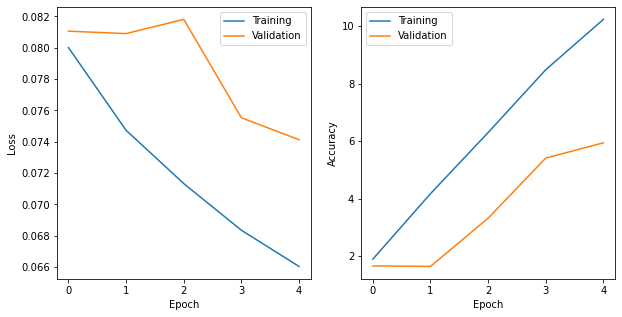

In [11]:
plot(loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist)


In [ ]:
'获取GPU信息'
if torch.cuda.is_available():
    GPU_nums = torch.cuda.device_count()
    print('got {} GPUs'.format(GPU_nums))
    for i_gpu in range(GPU_nums):
        print('GPU{}:{}'.format(i_gpu, torch.cuda.get_device_name(i_gpu)))
